In [40]:
import os
import json
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.io as sio
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [4]:
train = sio.loadmat("../data/train.mat")
test = sio.loadmat("../data/test.mat")
reference = sio.loadmat("../data/reference.mat")

reference.keys()

dict_keys(['__header__', '__version__', '__globals__', '0005'])

In [30]:
train["0001"][0][0][0]

array([[[ 3.34671783e-03,  3.30612138e-03,  1.46687738e-03, ...,
          1.41136766e-03,  1.54820065e-03,  2.94350645e-03],
        [ 5.35599751e-03,  6.23906205e-03,  6.14404173e-03, ...,
          7.86509694e-03,  8.75434469e-03,  8.43914924e-03],
        [ 4.81248129e-03,  4.72978164e-03,  3.43533959e-03, ...,
          3.52321836e-04,  1.33438743e-02,  2.56373432e-02],
        ...,
        [-1.97598249e-03, -1.37911719e-04,  3.66201972e-03, ...,
         -2.03931012e-02, -3.09544633e-02, -5.06945098e-02],
        [ 7.72472545e-04,  1.61619701e-03,  2.18350909e-03, ...,
          4.47519227e-02,  3.96857052e-02,  2.74528670e-02],
        [ 6.02367674e-03,  1.67615901e-03, -2.77612019e-03, ...,
          1.91907989e-02,  1.37089590e-02,  5.76590993e-03]],

       [[-6.06340545e-03, -6.35007298e-03, -5.46088932e-03, ...,
          1.70799219e-02,  1.60942897e-02,  1.58757545e-02],
        [-5.36461201e-02, -4.26188711e-02, -2.94343867e-02, ...,
          3.36723537e-03,  4.05160240e

In [31]:
reference["0005"][0][0][3]

array([[[-3.04968288e+00, -2.97075574e+00, -2.86376413e+00, ...,
         -3.86921291e-01, -3.44985218e-01, -3.08822006e-01],
        [-1.04095437e+00, -1.04353421e+00, -1.03445001e+00, ...,
         -2.03067964e-01, -1.75162756e-01, -1.54018598e-01],
        [ 2.26393516e-01,  3.95627097e-01,  5.94812874e-01, ...,
          4.71967826e-01,  3.32823378e-01,  1.99640685e-01]],

       [[-3.41431058e+00, -3.37559241e+00, -3.32127325e+00, ...,
         -3.27261936e+00, -3.27753051e+00, -3.28402498e+00],
        [-1.22697279e+00, -1.22361637e+00, -1.21382162e+00, ...,
         -1.26539715e+00, -1.27055964e+00, -1.27806391e+00],
        [-1.78952126e-02, -1.06169234e-02,  5.04716299e-04, ...,
         -3.81834319e-02, -4.55827747e-02, -5.71621786e-02]],

       [[-3.45566294e+00, -3.44212836e+00, -3.42320971e+00, ...,
         -3.34239014e+00, -3.28615416e+00, -3.20593591e+00],
        [-1.51501133e+00, -1.50870418e+00, -1.49496168e+00, ...,
         -1.37860645e+00, -1.34885227e+00, -1.327

In [39]:
ref_train_x = reference["0005"][0][0][0]
ref_train_y = reference["0005"][0][0][1]
ref_test_x = reference["0005"][0][0][2]
ref_test_y = reference["0005"][0][0][3]

print(
f"""
Train X shape: {ref_train_x.shape}
Train Y shape: {ref_train_y.shape}
Test  X shape: {ref_test_x.shape}
Test  Y shape: {ref_test_y.shape}
"""
)


Train X shape: (320, 16, 1000)
Train Y shape: (320, 3, 30)
Test  X shape: (320, 16, 1000)
Test  Y shape: (320, 3, 30)



# 訓練用データと評価用データの比較
- テスト用データの $x, y$ 座標の符号が訓練用データと逆転している可能性

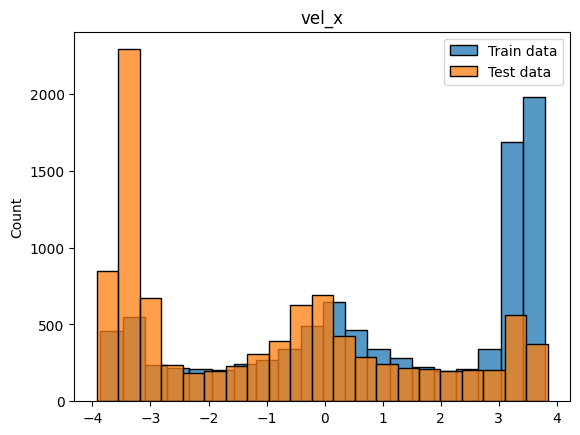

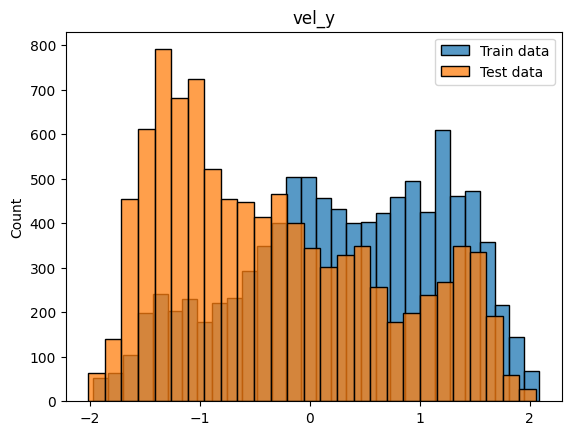

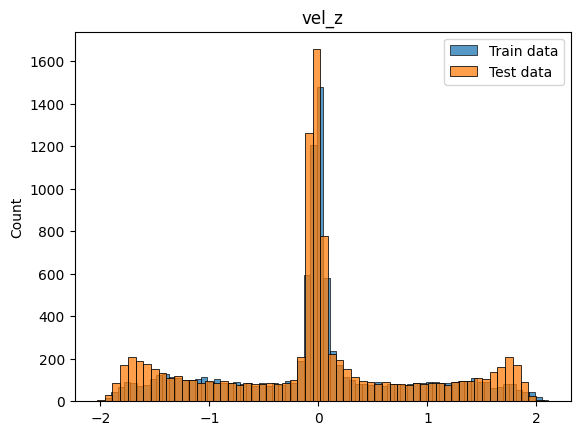

In [47]:
for i, axis in enumerate(["vel_x", "vel_y", "vel_z"]):
    sns.histplot(ref_train_y[:, i, :].flatten(), label="Train data")
    sns.histplot(ref_test_y[:, i, :].flatten(), label="Test data")
    plt.legend()
    plt.title(axis)
    plt.show()

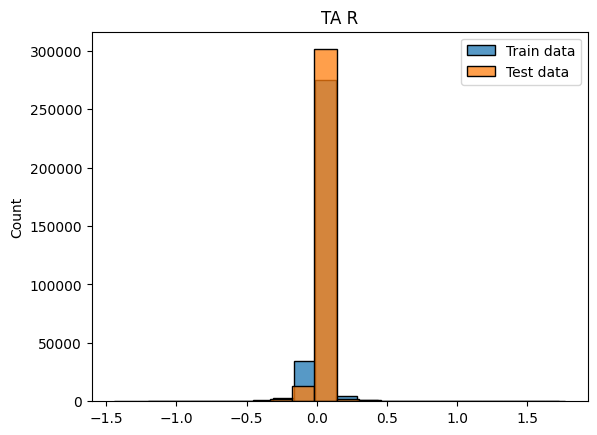

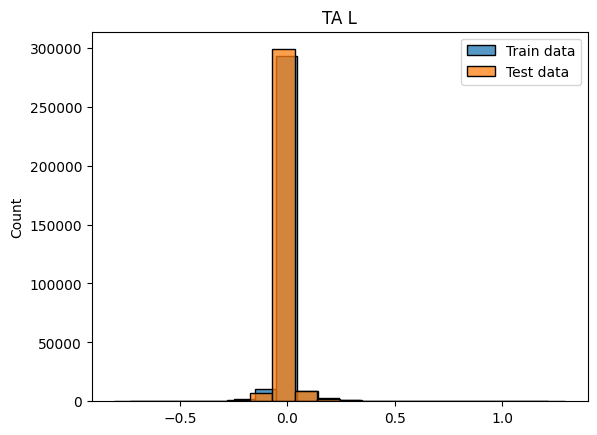

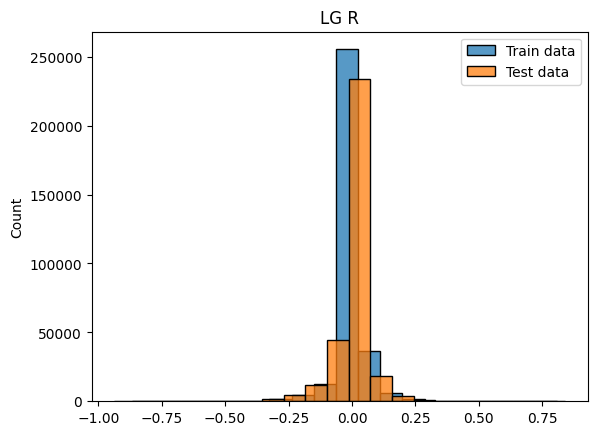

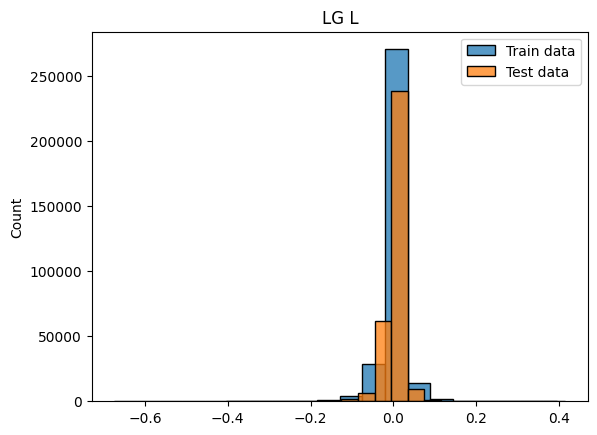

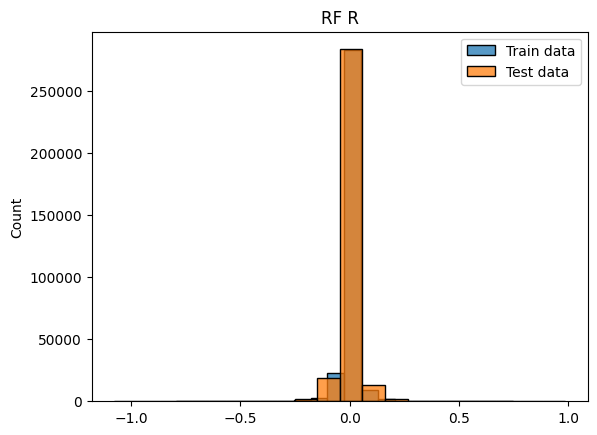

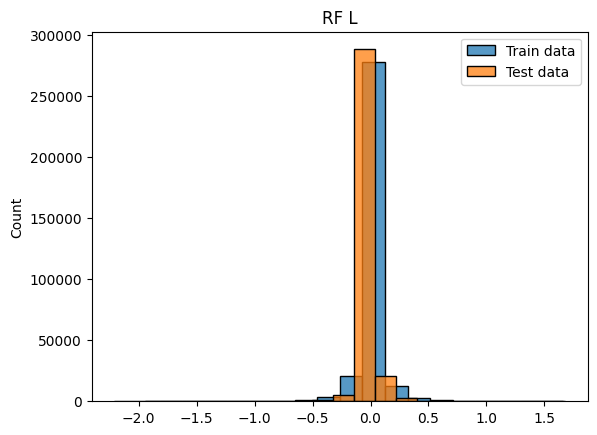

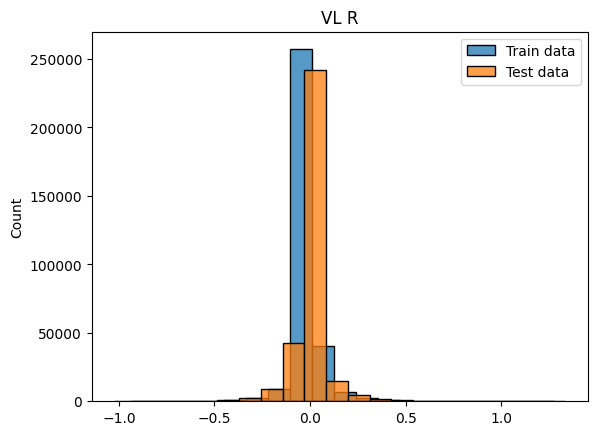

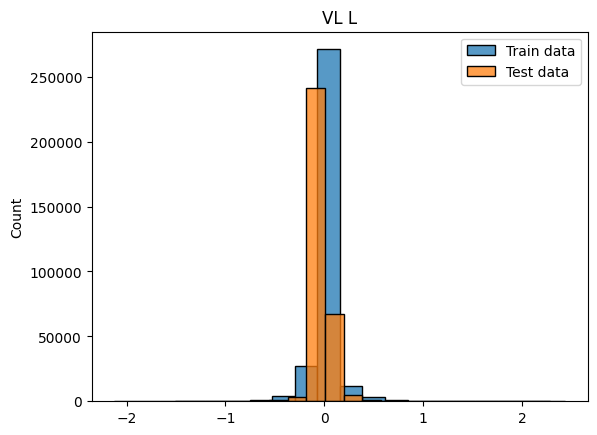

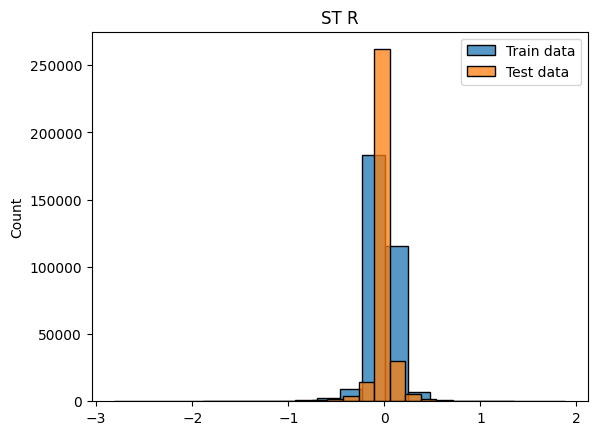

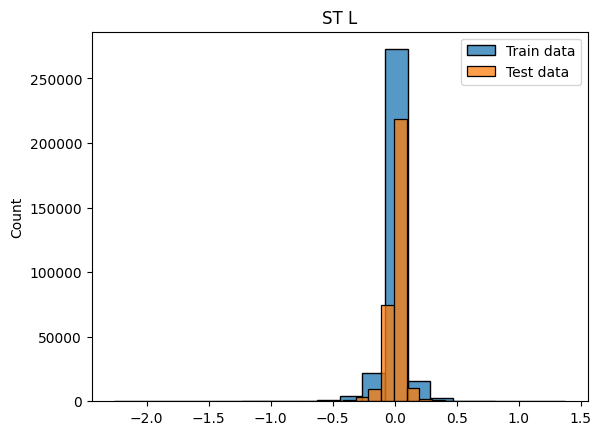

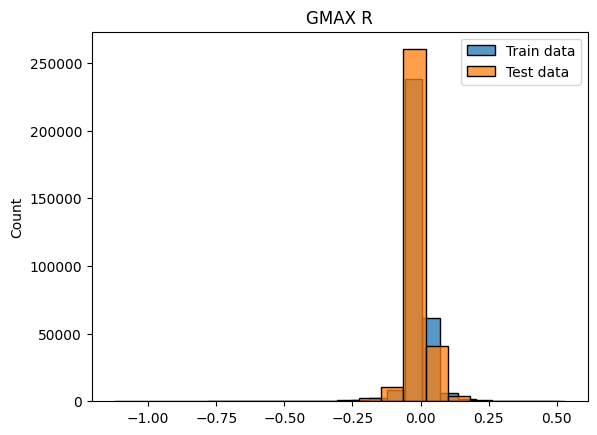

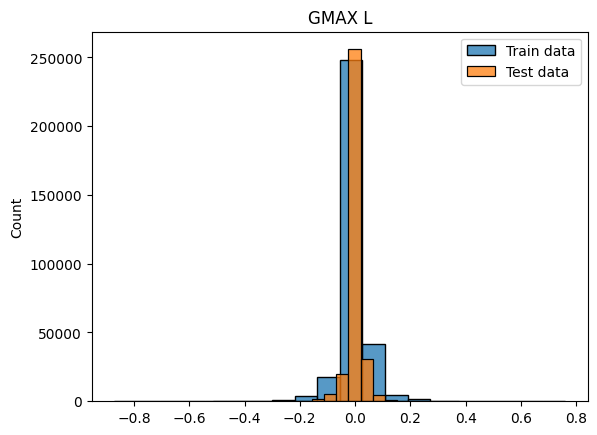

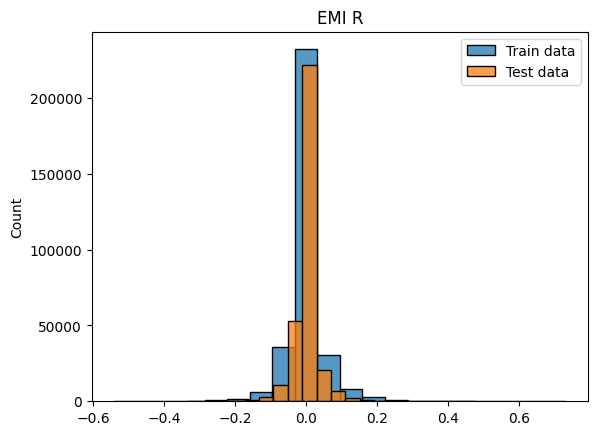

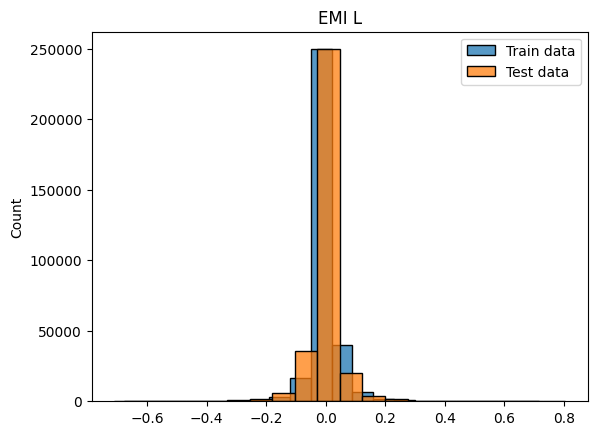

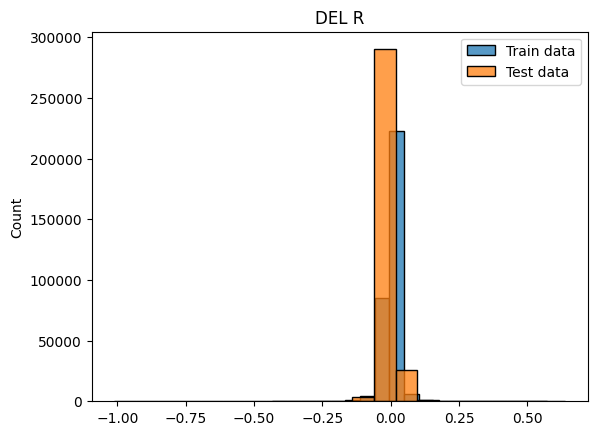

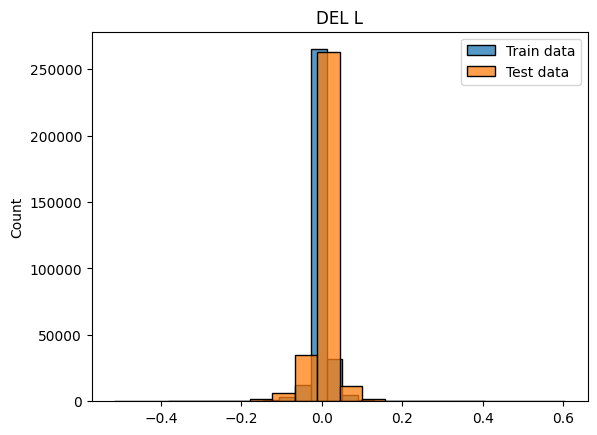

In [49]:
feature_name = [
    'TA R', 'TA L', 'LG R', 'LG L', 'RF R', 'RF L', 'VL R', 'VL L', 
    'ST R', 'ST L', 'GMAX R', 'GMAX L', 'EMI R', 'EMI L', 'DEL R', 'DEL L'
]

for i, col in enumerate(feature_name):
    sns.histplot(ref_train_x[:, i, :].flatten(), label="Train data", bins=20)
    sns.histplot(ref_test_x[:, i, :].flatten(), label="Test data", bins=20)
    plt.legend()
    plt.title(col)
    plt.show()

# 筋電データの前処理

In [116]:
def moveRMS(data, window=10):
    return np.convolve(np.sqrt(data**2), np.ones(window)/window, mode='same')

xt, lmd = boxcox(moveRMS(ref_train_x[0, 0, :]))

In [117]:
xt_valid = boxcox(moveRMS(ref_train_x[0, 0, :]), lmbda=lmd)

In [196]:
sample_data = ref_train_x.copy()
sample_data = sample_data.transpose(0, 2, 1)
d = np.apply_along_axis(moveRMS, axis=1, arr=sample_data)
sample_data.shape, d.shape

((320, 1000, 16), (320, 1000, 16))

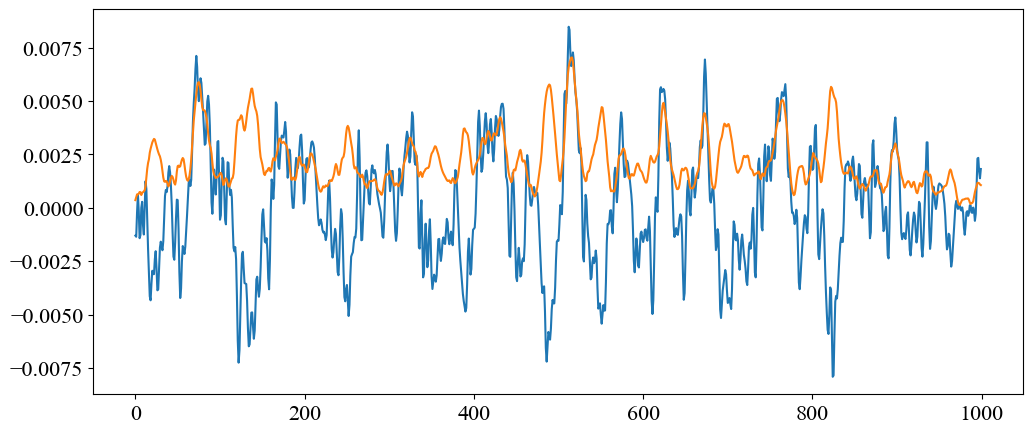

In [197]:
plt.figure(figsize=(12, 5))
plt.plot(sample_data[0, :, 15])
plt.plot(d[0, :, 15])

In [198]:
def _boxcox(x):
    xt, _ = boxcox(x)
    return xt

transformed = np.apply_along_axis(_boxcox, axis=1, arr=d)
transformed.shape

(320, 1000, 16)

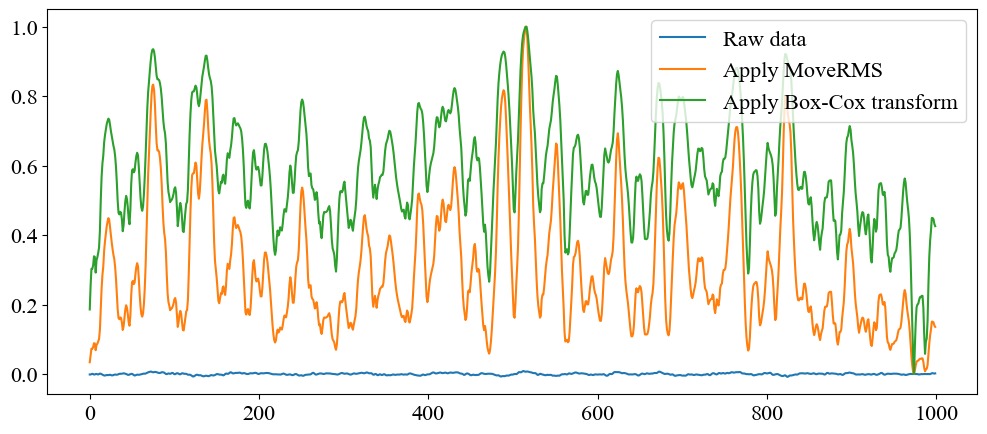

In [199]:
select_feature = 15
plt.figure(figsize=(12, 5))
raw_sample = sample_data[0, :, select_feature]
plt.plot(sample_data[0, :, select_feature], label="Raw data")
mm1 = MinMaxScaler()
apply_moveRMS = mm1.fit_transform(d[0, :, select_feature].reshape(-1, 1))
plt.plot(apply_moveRMS, label="Apply MoveRMS")
mm2 = MinMaxScaler()
apply_boxcox = mm2.fit_transform(transformed[0, :, select_feature].reshape(-1, 1))
plt.plot(apply_boxcox, label="Apply Box-Cox transform")
plt.legend()
plt.show()

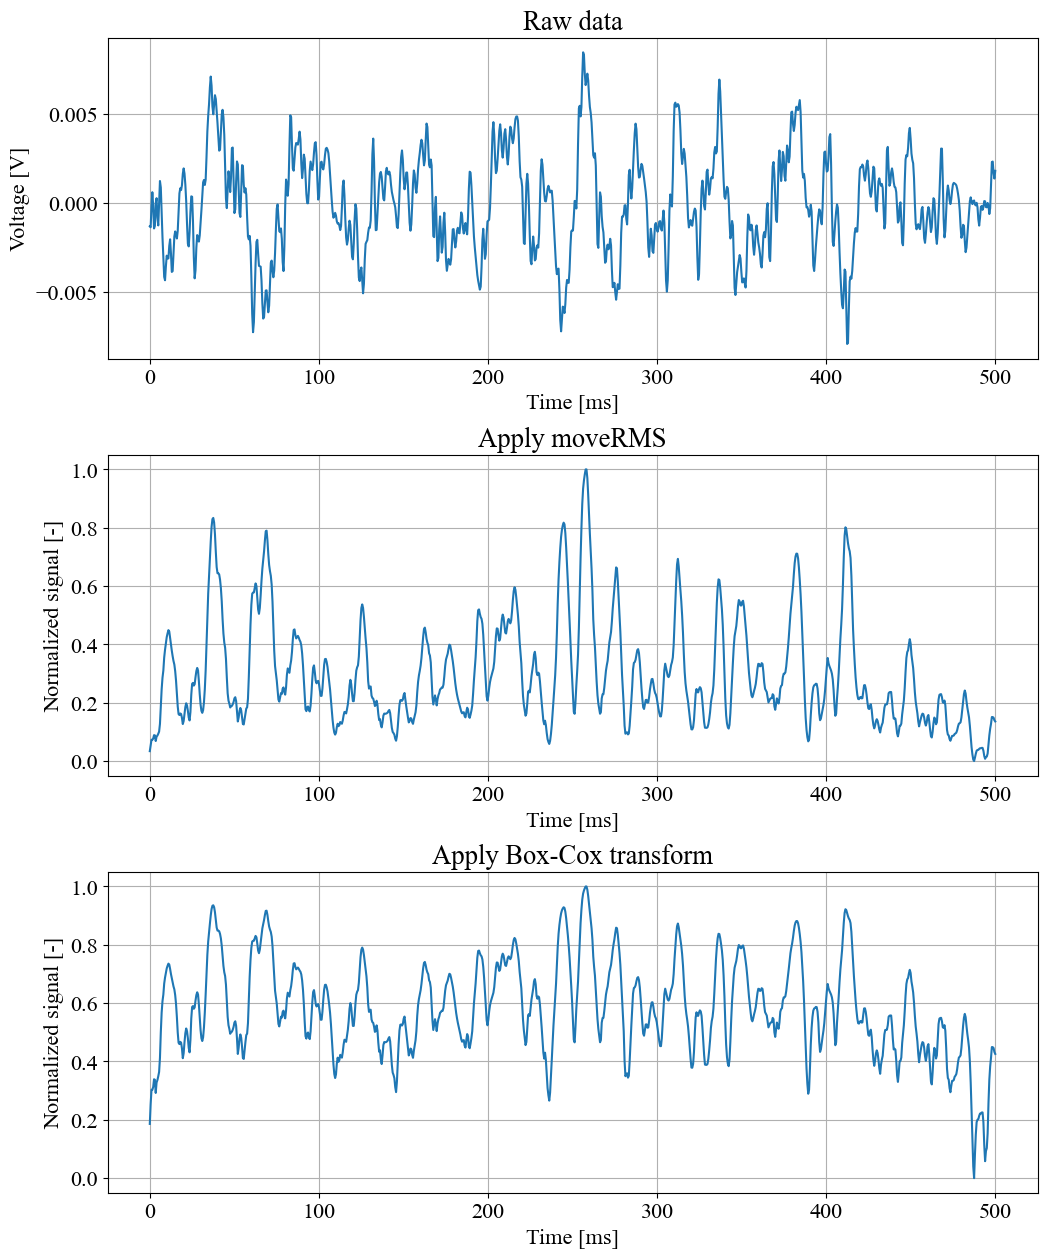

In [200]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16

fig = plt.figure(figsize=(12, 15))
fig.subplots_adjust(hspace=0.3)
t = np.linspace(0, 500, 1000)

ax0 = fig.add_subplot(311)
ax0.plot(t, raw_sample)
ax0.set_title("Raw data")
ax0.set_xlabel("Time [ms]")
ax0.set_ylabel("Voltage [V]")
ax0.grid()

ax1 = fig.add_subplot(312)
ax1.plot(t, apply_moveRMS)
ax1.set_title("Apply moveRMS")
ax1.set_xlabel("Time [ms]")
ax1.set_ylabel("Normalized signal [-]")
ax1.grid()

ax2 = fig.add_subplot(313)
ax2.plot(t, apply_boxcox)
ax2.set_title("Apply Box-Cox transform")
ax2.set_xlabel("Time [ms]")
ax2.set_ylabel("Normalized signal [-]")
ax2.grid()

In [187]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")
# sys.path.append("../src/preprocess")

from src.preprocess.emg import EmgEncoder

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [201]:
train_x = reference["0005"][0][0][0]

emg_encoder = EmgEncoder(num_features=16, num_sequence=1000, window=10)
train_x_transformed = emg_encoder.fit_transform(train_x)
simple_return = emg_encoder.apply_moveRMS(train_x)

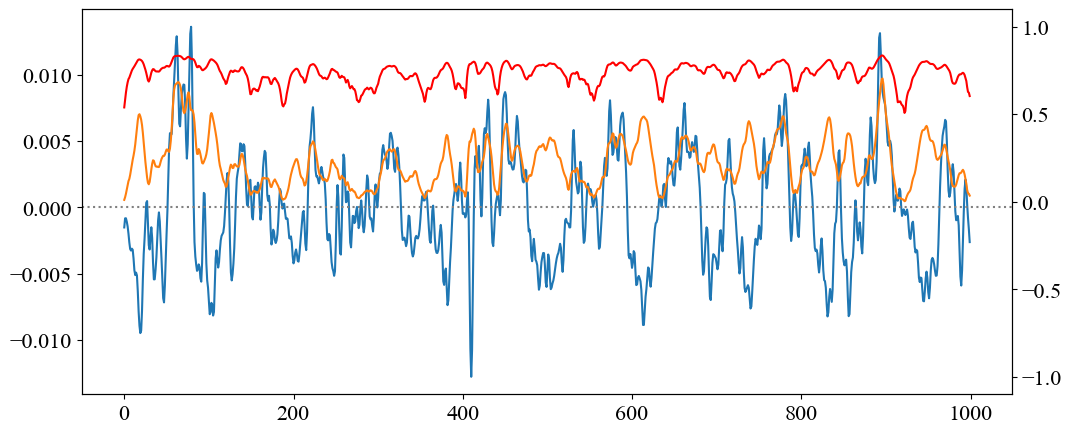

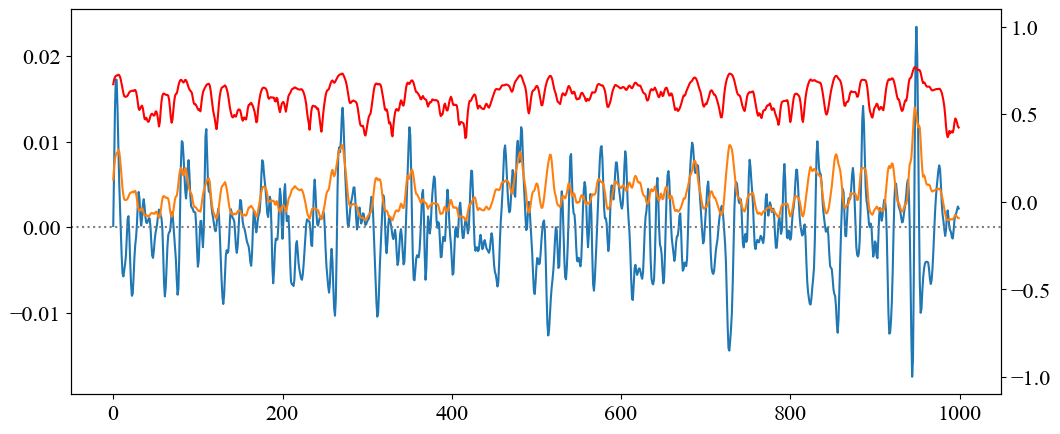

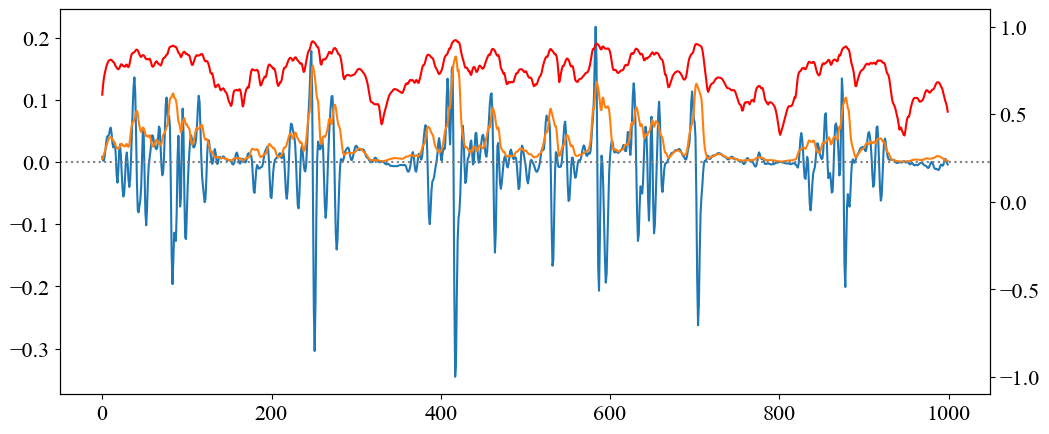

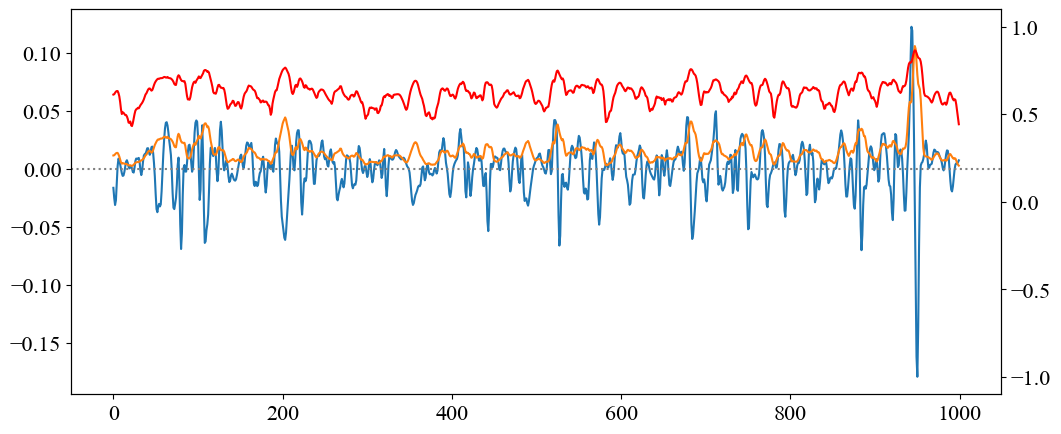

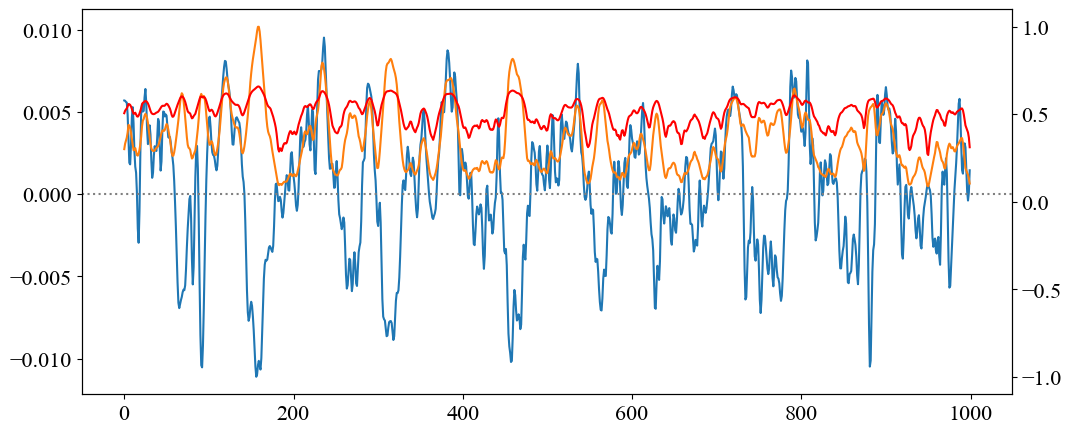

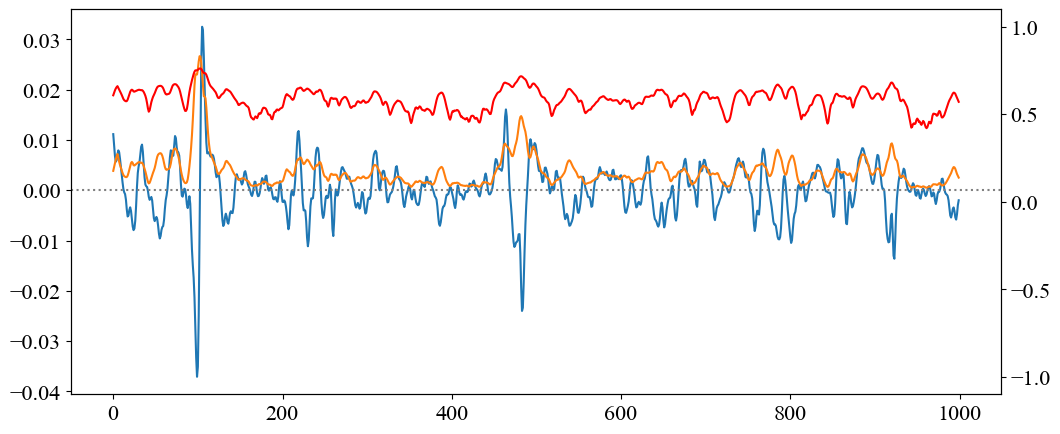

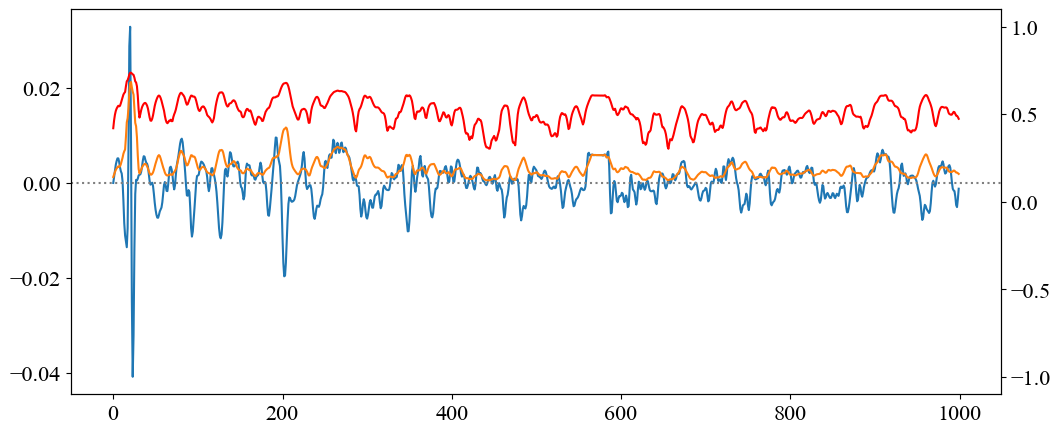

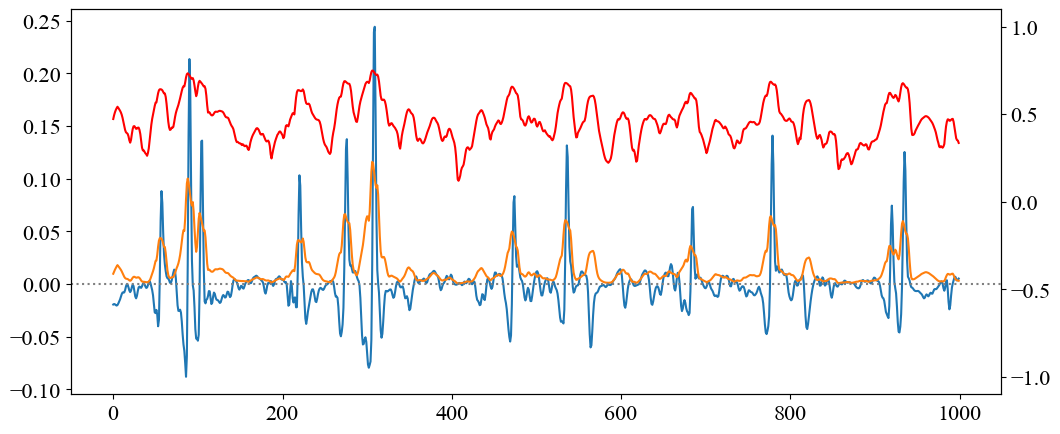

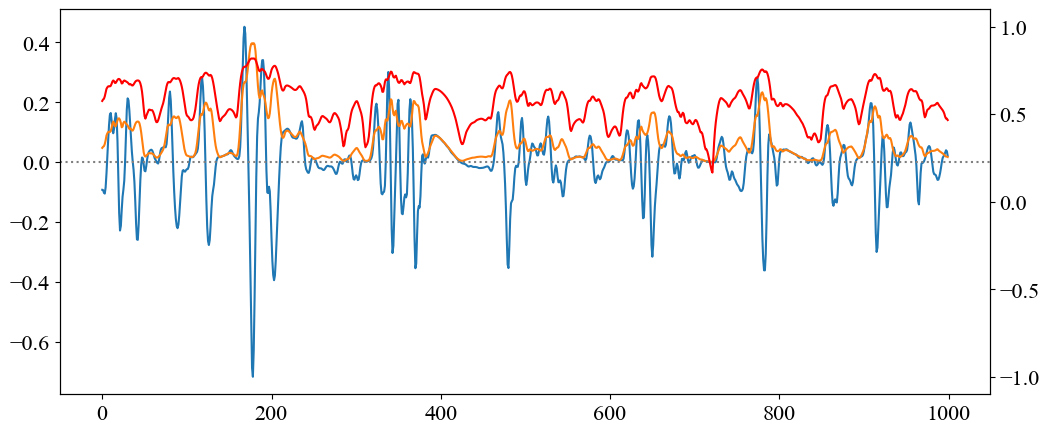

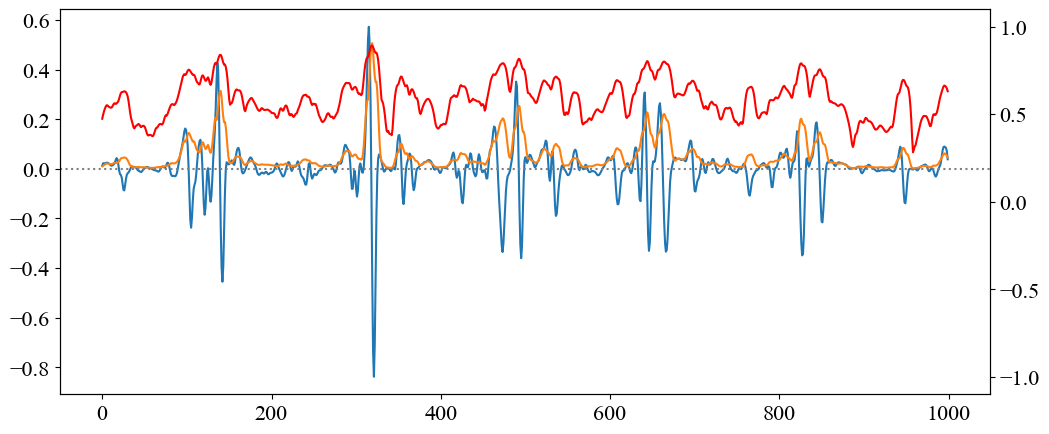

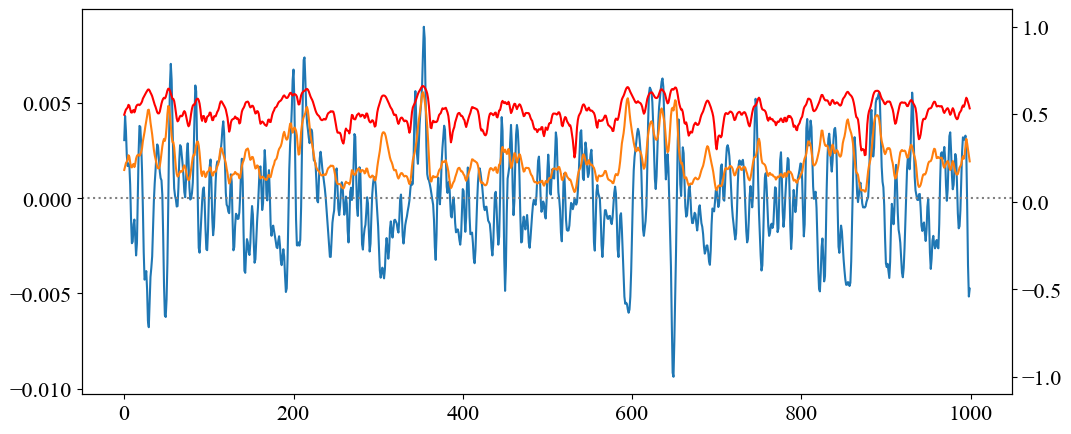

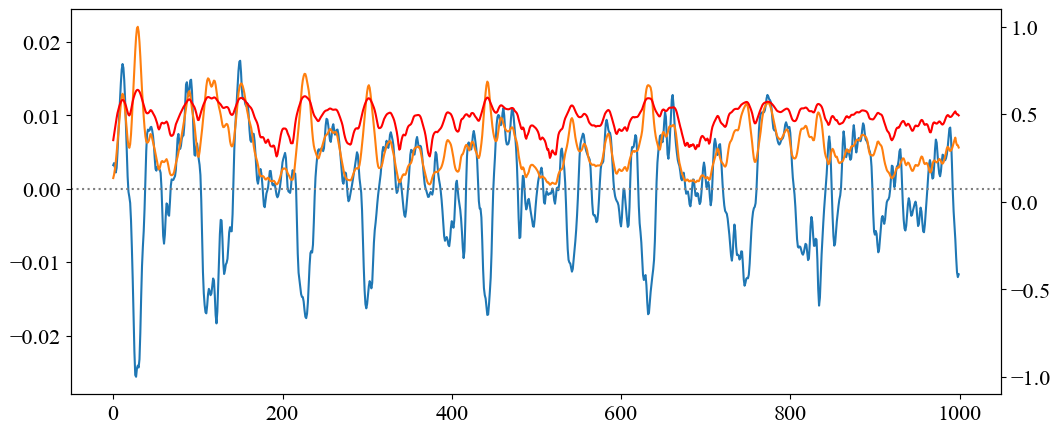

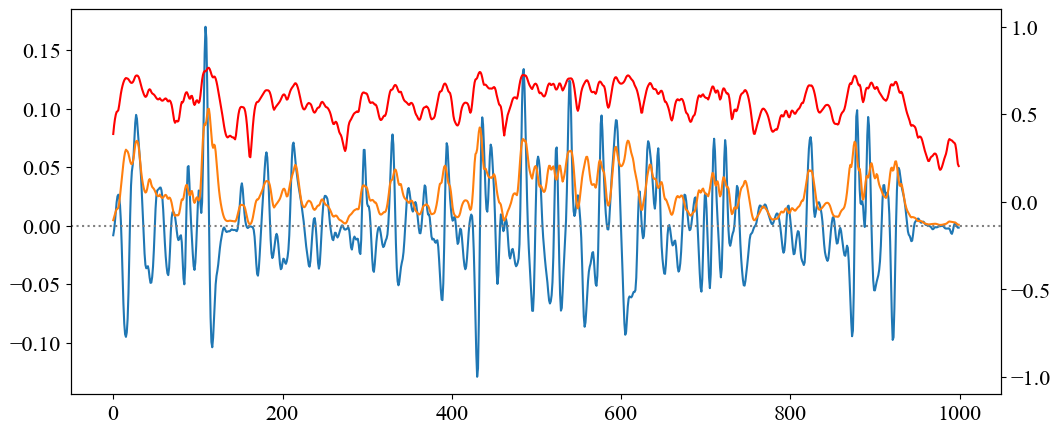

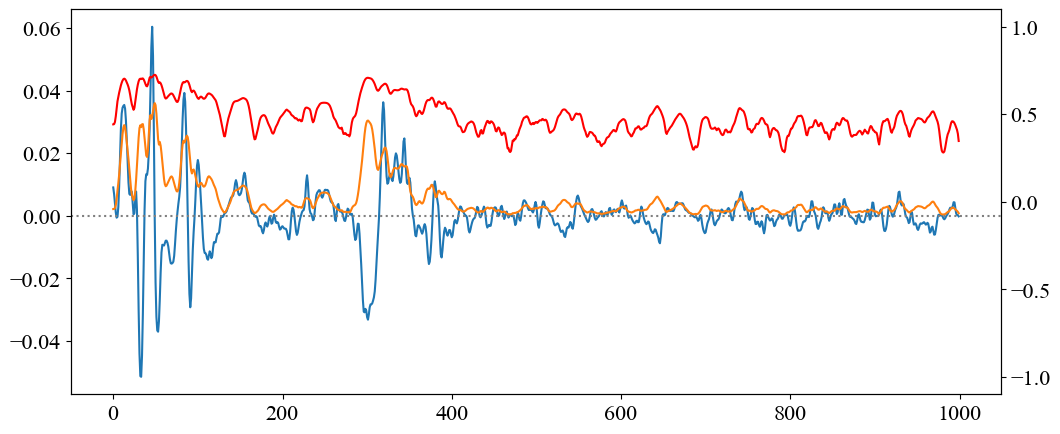

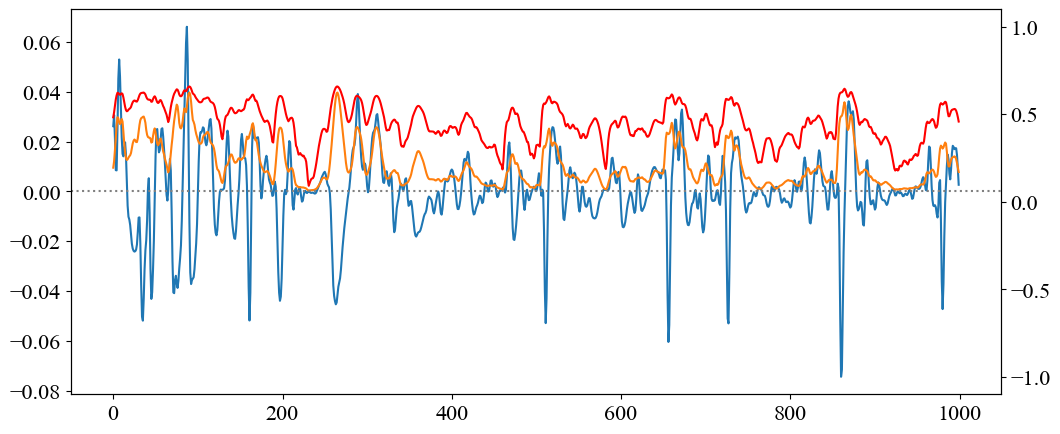

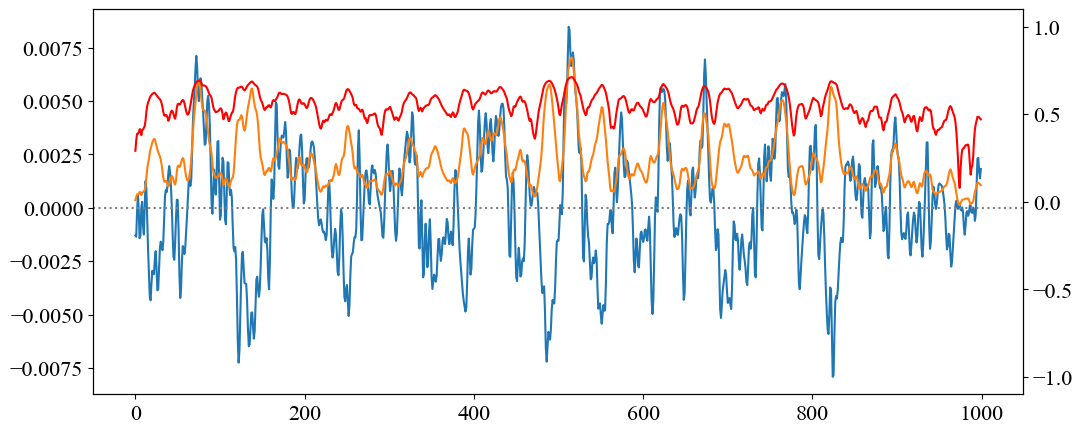

In [202]:

for select_feature in range(16):

    fig = plt.figure(figsize=(12, 5))
    ax0 = fig.add_subplot(111)
    raw_sample = train_x[0, select_feature, :]
    ax0.plot(raw_sample, label="Raw data")
    ax0.plot(simple_return[0, :, select_feature])
    # ax0.set_ylim([-0.04, 0.04])
    ax0.axhline(0, ls="dotted", color="gray")

    ax1 = ax0.twinx()
    ax1.plot(train_x_transformed[0, :, select_feature], label="Apply Box-Cox transform", color="r")
    ax1.set_ylim([-1.1, 1.1])
    plt.show()

In [203]:
user_list = ["0001", "0002", "0003", "0004"]

for user in tqdm(user_list):
    train_x = train[user][0][0][0]
    test_x = test[user][0][0][0]
    
    emg_encoder = EmgEncoder()
    train_x = emg_encoder.fit_transform(train_x)
    test_x = emg_encoder.transform(test_x)
    
    np.save(f"../data/processed/train_{user}", train_x)
    np.save(f"../data/processed/test_{user}", test_x)

  0%|          | 0/4 [00:00<?, ?it/s]